# Sheet 2: Least-squares and Maximum-likelihood Estimators

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from iminuit import Minuit
from resample.bootstrap import variance
from scipy.optimize import minimize

rng = np.random.default_rng(seed=1)

---

## Task 3: Maximum-Likelihood Estimator

### 3.1

Calculate the maximum-likelihood estimator _analytically_ for the probability density function $f(t; \theta)$ and $n$ independent measurements $t_i$. 

$$f(t; \theta) = \frac{1}{2\theta\sqrt{t}} \cdot \exp\left(-\frac{1}{\theta}\sqrt{t}\right) \quad \text{for } t>0$$

---

---

### 3.2

_Analytically_ compute the uncertainty estimate $\hat \sigma_\theta$ of the maximum-likelihood estimator $\hat \theta$.

---

---

### 3.3

In practice, the only challenge when using maximum-likelihood estimation is to write down the correct likelihood (product of probabilities of data under the model) for the following problems.

Write the general likelihood function for an experiment whose result is a histogram over the random variable $x$ with a probability density function $f(x; \theta)$.   
The total number of samples $n$ in the histogram is not fixed but follows a Poisson distribution with unknown expectation $\mu$.

The histogram may not cover the full range of $x$ values. Does the likelihood function change then?

Remember that the likelihood of two independent events is the product of their individual likelihoods.

---

---

## Task 4: Maximum-Likelihood Fit

We now perform a maximum-likelihood fit for the problem in Task 2. The maximum-likelihood method does not require binning of the data, which can be an advantage.   
The fit is easier to implement and there is no need to choose an appropriate binning for the data, which preserves the essential information.   
However, it can make the fit also very time-consuming if the data sample is very large. [A comparison can be found here](https://iminuit.readthedocs.io/en/stable/notebooks/binned_vs_unbinned.html). 

It is always possible to write a likelihood for any statistical problem, also for fitting binned data in a histogram, but we will not look into that here.

### 4.1

Write code for a negative log-likelihood for the unbinned sample from Task 2. Use the probability density $\rho(x)$ that you have previously calculated.

Use `minimize` from `scipy.optimize` to minimize the negative log-likelihood for a random sample generated using the code from Task 2.1. Use the same `bounds` as in Task 2.4.

---

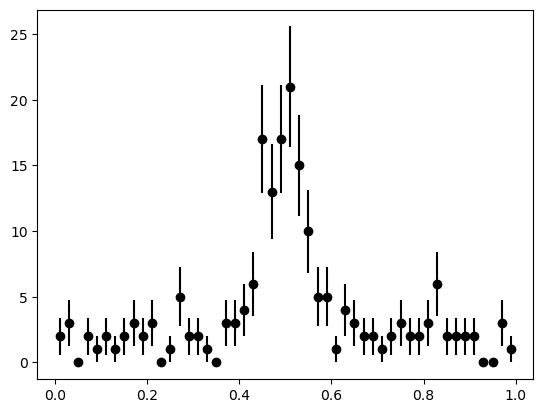

In [32]:
def generate(rng, mu, sigma):
    ns, nb = rng.poisson(100, size=2)
    b = rng.uniform(0, 1, size=nb)
    s = rng.normal(mu, sigma, size=ns)
    x = np.append(s, b)
    return x


def generate_histogram(x):
    ntot = len(x)
    n, xe = np.histogram(x, range=(0, 1), bins=50)
    return ntot, n, xe


mu_true = 0.5
sigma_true = 0.05

x = generate(rng, mu_true, sigma_true)
ntot, n, xe = generate_histogram(x)

cx = 0.5 * (xe[1:] + xe[:-1])
plt.errorbar(cx, n, n**0.5, fmt="ok")


def rho(x, fs, mu, sigma):
    return fs * st.norm.pdf(x, mu, sigma) + (1 - fs)


def P(x, fs, mu, sigma):
    return fs * st.norm.cdf(x, mu, sigma) + (1 - fs) * x


def expected(xe, N, fs, mu, sigma):
    return np.diff(P(xe, fs, mu, sigma)) * N


start = (0.3, 0.4, 0.1)
bounds = ((0.1, 0.9), (0.3, 0.7), (0.01, 0.2))

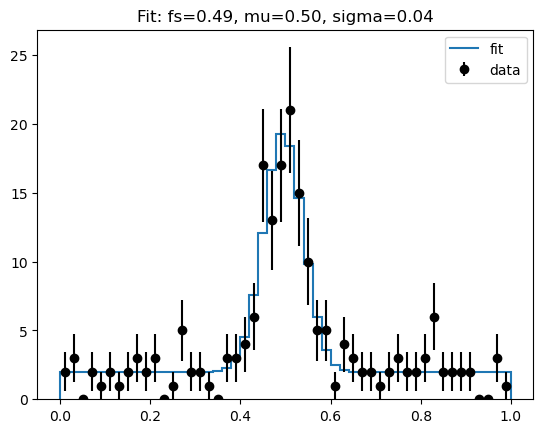

In [33]:
start = (0.3, 0.4, 0.1)
bounds = ((0.1, 0.9), (0.3, 0.7), (0.01, 0.2))

def nll(x, fs, mu, sigma):
    return -np.sum(np.log(rho(x, fs, mu, sigma)))


def fit(x):
    results = minimize(lambda params: nll(x, *params), start, bounds=bounds)
    return results.x


param = fit(x)
plt.errorbar(cx, n, n**0.5, fmt="ok", label="data")
plt.stairs(expected(xe, ntot, *param), xe, label='fit', linewidth=1.5)
plt.title(f"Fit: fs={param[0]:.2f}, mu={param[1]:.2f}, sigma={param[2]:.2f}")
plt.legend();

---

### 4.2

Numerically compute an estimate of the parameter uncertainties from the log-likelihood function with the `iminuit` package. What is the estimated uncertainty of $f_s$?

*Hints*

* Create an instance of the `Minuit` class from the `iminuit` package. Use the parameter values from `minimize` as starting values.
* Since our function is a negative log-likelihood, we need to set the `errordef` attribute of the `Minuit` instance to `Minuit.LIKELIHOOD`.

In practice, you would normally also do the minimization with `Minuit` and use the built-in cost function `iminuit.cost.UnbinnedNLL` instead of a hand-written one for convenience. See the [iminuit docs for more information on how to perform fits using the built-in cost functions](https://iminuit.readthedocs.io/en/stable/index.html).

---

In [34]:
m = Minuit(lambda par: nll(x, *par), param)
m.errordef = Minuit.LIKELIHOOD
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -82.53                     │              Nfcn = 35               │
│ EDM = 1.68e-12 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.49    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │   0.495   │   0.006   │            │            │         │         │       │
│ 2 │ x2   │   0.043   │   0.005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │  0.00218        0 0.076e-3 │
│ x1 │        0 3.02e-05 0.001e-3 │
│ x2 │ 0.076e-3 0.001e-3 2.47e-05 │
└────┴────────────────────────────┘

---

### 4.3

Repeat the fits from Task 4.1 with independent samples to get the distribution of the parameter $f_s$.

Is the $f_s$ distribution biased?

Does the standard deviation of the distribution agree with the estimated uncertainty from Task 4.2?

---

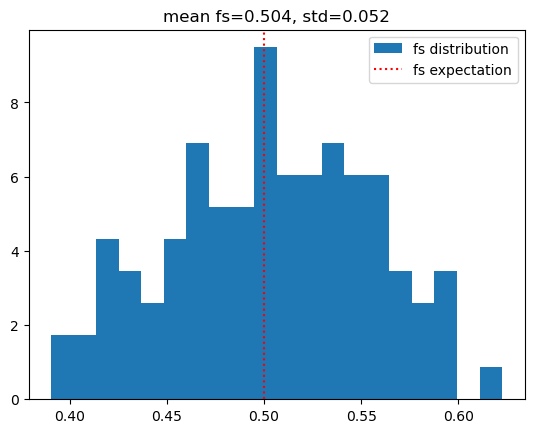

In [35]:
fs = []

for _ in range(100):
    x = generate(rng, mu_true, sigma_true)
    ntot, n, xe = generate_histogram(x)
    param = fit(x)
    fs.append(param[0])

plt.hist(fs, bins=20, density=True, label='fs distribution')
plt.axvline(.5, color="r", ls=":", label='fs expectation')
plt.title(f"mean fs={np.mean(fs):.3f}, std={np.std(fs):.3f}")
plt.legend();


In [36]:
m = Minuit(lambda par: nll(x, *par), param)
m.errordef = Minuit.LIKELIHOOD
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -92.25                     │              Nfcn = 35               │
│ EDM = 1.49e-10 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.51    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │   0.499   │   0.005   │            │            │         │         │       │
│ 2 │ x2   │   0.042   │   0.005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        x0        x1        x2 │
├────┼───────────────────────────────┤
│ x0 │   0.00223 -0.013e-3  0.100e-3 │
│ x1 │ -0.013e-3  2.77e-05 -0.003e-3 │
│ x2 │  0.100e-3 -0.003e-3  2.92e-05 │
└────┴───────────────────────────────┘

---

### 4.4 (Bonus)

Do the same as in 4.3, but this time use the bootstrap to generate samples from the original dataset to get the distribution of the parameter $f_s$.

Does the standard deviation of the distribution agree with the estimated uncertainty from Task 4.2?

---

In [38]:
variance(lambda x: fit(x)[0], x, size = 1000)** 0.5

np.float64(0.04805190033937871)